# Trabajo Práctico N°2 
Asignatura: Minería de Datos.

Carrera: Tecnicatura Universitaria en Inteligencia Artificial.

Año: 2024.

Integrante: López Ceratto, Julieta.

# Librerias a utilizar

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import silhouette_score,silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import random
from sklearn.preprocessing import LabelEncoder

# Funciones

In [3]:
def plot_multiple_conf_matrices(y_real_list, y_pred_list, titles):      
    num_matrices = len(y_real_list)
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    # Lista de colormaps para seleccionar aleatoriamente
    colormaps = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'coolwarm', 'cividis', 'magma']
    for i in range(num_matrices):
        color = random.choice(colormaps)
        cm = metrics.confusion_matrix(y_real_list[i], y_pred_list[i])
        sns.heatmap(cm, annot=True, ax=axes[i], fmt='d', cmap=color)
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Predicted labels')
        axes[i].set_ylabel('True labels')

    # Oculta cualquier eje restante si hay menos de 4 matrices
    for j in range(num_matrices, 4):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [4]:
def pd_metricas_clasifier(dict_modelos:dict, m_type: str = 'clasifier'):
    metricas_modelos = pd.DataFrame()    
    for key,value in dict_modelos.items():
        valores_modelo = value[0]
        metrica_clas = {
        'Nombre_Modelo': key,
        'Max_profundidad' : valores_modelo[0],
        'Min_obs' : valores_modelo[1],
        'Min_Obs_x_Sep' : valores_modelo[2],
        'Criterio_Sep' : valores_modelo[3]
        }
        if m_type == 'clasifier':
            for i in range(1,len(value)):
                y_real,y_pred = value[i]
                metrica_clas[f'Precision Test {i}'] = precision_score(y_real,y_pred, pos_label=0, average='weighted'),
                metrica_clas[f'Recall Test {i}'] = recall_score(y_real,y_pred, pos_label=0, average='weighted')
                metrica_clas[f'Accuracy Test {i}'] = accuracy_score(y_real,y_pred),
                metrica_clas[f'F1-Score Test {i}'] = f1_score(y_real,y_pred, pos_label=0, average='weighted')
        elif m_type == 'regressor':
            for i in range(1,len(value)):
                y_real,y_pred = value[i]
                metrica_clas[f'MAE Test {i}'] = mean_absolute_error(y_real,y_pred),
                metrica_clas[f'MSE Test {i}'] = mean_squared_error(y_real,y_pred)
                metrica_clas[f'RMSE Test {i}'] = np.sqrt(mean_squared_error(y_real,y_pred)),
        metricas_modelos = pd.concat([metricas_modelos,pd.DataFrame(metrica_clas)])
    
    return metricas_modelos

# Carga de datos

In [5]:
df = pd.read_csv('./src/1000_Companies.csv')

In [6]:
df

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.800,471784.1000,New York,192261.83000
1,162597.70,151377.590,443898.5300,California,191792.06000
2,153441.51,101145.550,407934.5400,Florida,191050.39000
3,144372.41,118671.850,383199.6200,New York,182901.99000
4,142107.34,91391.770,366168.4200,Florida,166187.94000
...,...,...,...,...,...
995,54135.00,118451.999,173232.6695,California,95279.96251
996,134970.00,130390.080,329204.0228,California,164336.60550
997,100275.47,241926.310,227142.8200,California,413956.48000
998,128456.23,321652.140,281692.3200,California,333962.19000


# Punto 1

## Análisis descriptivo

In [7]:
## Cantidad de columnas y sus tipos de datos
print(f'El DataFrame cuenta con un total de {len(df.columns)} columnas:')
df.dtypes

El DataFrame cuenta con un total de 5 columnas:


RyD_Spend         float64
Administration    float64
MarketingSpend    float64
State              object
Profit            float64
dtype: object

In [8]:
print(f'Cada columna se comporta de la siguiente manera:')
df.describe()

Cada columna se comporta de la siguiente manera:


,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


- RyD_Spend: Toma valores desde 0,0 a 165.349, su promedio es de 81.669 y su mediana de 79.936, lo que infiere que no tiene presencia de atípicos.
- Administración: Toma valores desde 51.283 a 321.652, su promedio es de 122.963 y su mediana de 122.421, lo que infiere que no tiene presencia de atípicos. Esta variable posee un mayor RIC que la anterior.
- MarkentingSpend: Toma valores desde 0,0 a 471784, su promedio es de 226.205 y su mediana de 224.517, lo que infiere que no tiene presencia de atípicos.
- Profit: Toma valores desde 14.681 a 476.485, su promedio es de 119.546 y su mediana de 117.641, lo que infiere que no tiene presencia de atípicos.

Si se quiere ver en histograma:


array([[<Axes: title={'center': 'RyD_Spend'}>,
        <Axes: title={'center': 'Administration'}>],
       [<Axes: title={'center': 'MarketingSpend'}>,
        <Axes: title={'center': 'Profit'}>]], dtype=object)

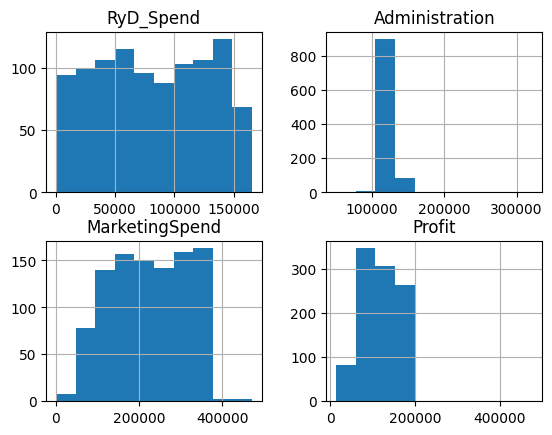

In [9]:
print(f'Si se quiere ver en histograma:')
df.hist()

<Axes: xlabel='State', ylabel='Count'>

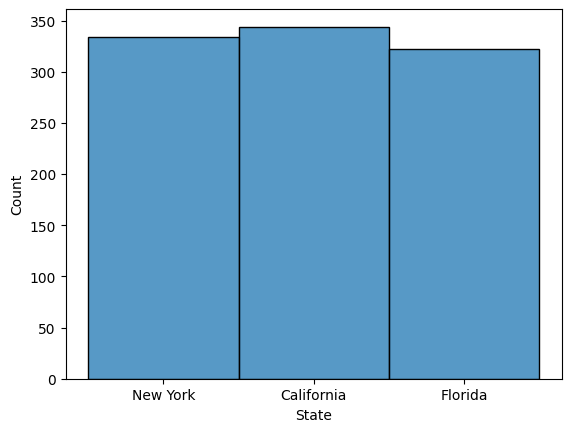

In [10]:
sns.histplot(df['State'])

Se puede ver que las variables RyD_Spend, MarketingSpend y Profit tienen una distribución uniforme, sin la presencia de atípicos visibles.

Por otro lado, en cuanto a la varibale Administración, la misma se concentra casi en su totalidad en el valor 900 aproximado, teniendo algunos caos atípicos en 100 a su derecha y cercanos a 0 a la izquierda.

<Axes: >

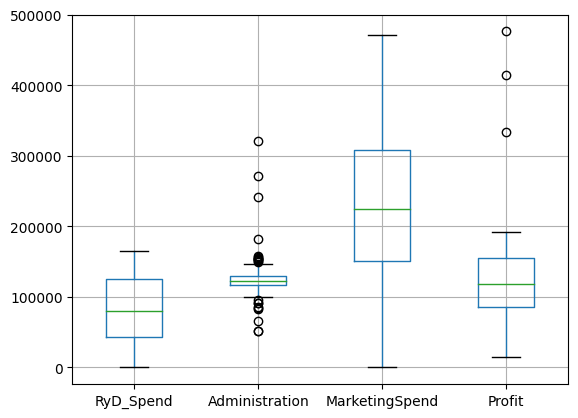

In [11]:
##Vemos la distribución en forma de boxplot
df.boxplot()

Podemos ver que las inferencias acerca de los atípicos en el primer bloque se confirman para las variables de RyD_Spend y Marketing_Spend, sin embargo, no para la variable de Administration ya que esto sólo era visible mediante boxplot. Esto se debe a que posee atípicos tanto por encima como por debajo de Q3 y Q1 respectivamente.
Profit solo tiene 3 atípicos por encima de su Q3.

Por otro lado, podemos observar que la variable MarketingSpend tiene una varianza mucho más notable que el resto, mientras que Profit y RyD_Spend se manejan con varianzas similares; finalmente, Administration -como ya se dejaba ver en el histograma- tiene una varianza muy pequeña.

Para terminar de confirmar si son atípicos, observamos las mismas variables diferenciadas ahora por la columna 'State":

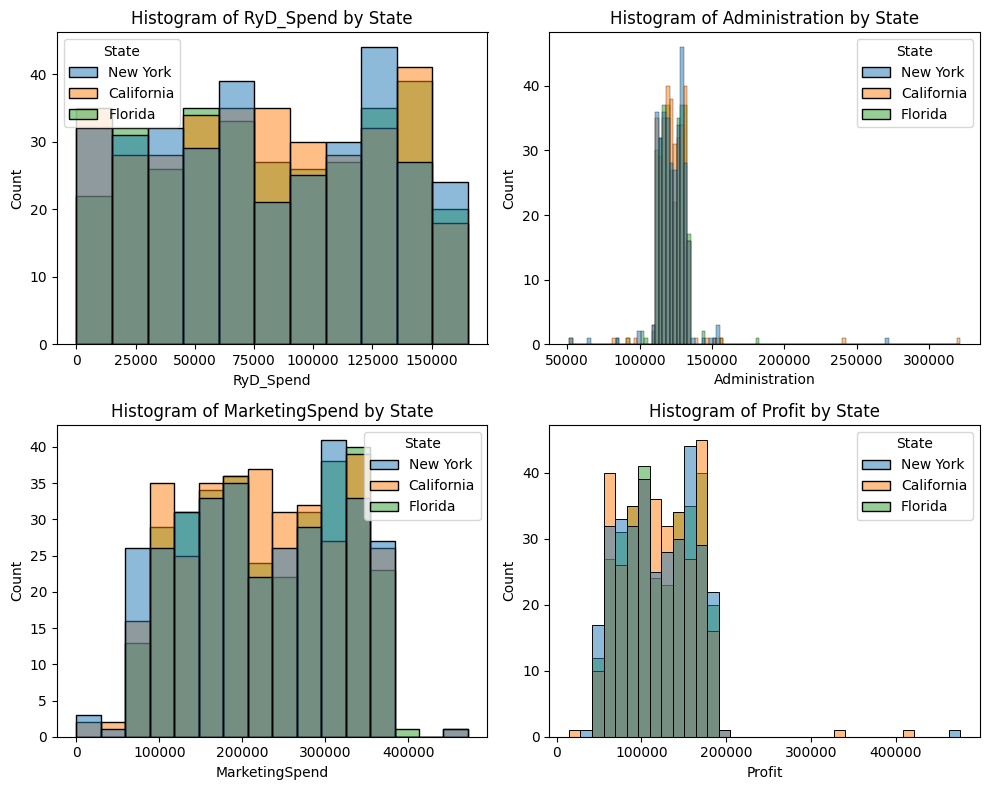

In [12]:
# Selecciona solo las columnas numéricas
numeric_columns = df.select_dtypes(include='number').columns

# Configura el tamaño del grid: 2 gráficos por fila
fig, axes = plt.subplots(len(numeric_columns) // 2 + len(numeric_columns) % 2, 2, figsize=(10, len(numeric_columns) * 2))

# Aplanar la matriz de axes para recorrer más fácilmente
axes = axes.flatten()

# Itera sobre las columnas numéricas y grafica los histogramas
for i, col in enumerate(numeric_columns):
    sns.histplot(data=df, x=col, hue='State', kde=False, ax=axes[i])
    axes[i].set_title(f'Histogram of {col} by State')

# Elimina gráficos extra si hay un número impar de columnas
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Podemos confirmar que se tratan de atípicos ya que no hay tendencias de comportamiento para un estado específico que sugieran que esos valores atípicos sean en realidad parte normal de los valores para un estado en específico.

### Presencia de Null

In [13]:
df.isnull().any()

RyD_Spend         False
Administration    False
MarketingSpend    False
State             False
Profit            False
dtype: bool

## Observación del balanceado

In [14]:
df['State'].value_counts()

State
California    344
New York      334
Florida       322
Name: count, dtype: int64

Se puede observar que el df se encuentra relativamente balanceado, siendo la máxima diferencia entre una clase y otra de 24 filas, lo que en un dataframe de 1000 no es una representación muy grande.

## Correlación.

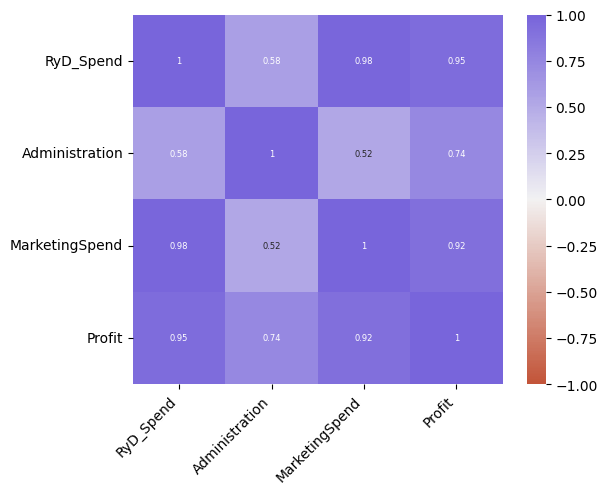

In [15]:
corr = df.drop(columns='State').corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 270, n=300),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

Las variables más correlacionadas entre sí son:
- RyD_Spend - Profit: tienen una correlación casi lineal (0.95 positiva).
- MarketingSpend - Profit: correlación positiva de 0.92, casi lineal.
- Administration - Profit: 0.74 positiva, es también una correlación fuerte.

La correlación más baja es de 0.52 positiva entre Administrattion y MarketingSpend.

En general, hay correlaciones bastante fuertes entre las variables.

No hay presencia de correlaciones negativas.

## Estandarización

### Division train-test

In [16]:
df_encoded = pd.get_dummies(df, columns=['State'], drop_first=True)

In [17]:
df_encoded

,RyD_Spend,Administration,MarketingSpend,Profit,State_Florida,State_New York
0,165349.20,136897.800,471784.1000,192261.83000,False,True
1,162597.70,151377.590,443898.5300,191792.06000,False,False
2,153441.51,101145.550,407934.5400,191050.39000,True,False
3,144372.41,118671.850,383199.6200,182901.99000,False,True
4,142107.34,91391.770,366168.4200,166187.94000,True,False
...,...,...,...,...,...,...
995,54135.00,118451.999,173232.6695,95279.96251,False,False
996,134970.00,130390.080,329204.0228,164336.60550,False,False
997,100275.47,241926.310,227142.8200,413956.48000,False,False
998,128456.23,321652.140,281692.3200,333962.19000,False,False


In [18]:
X = df_encoded.drop(columns='Profit')
y = df_encoded['Profit']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
#Segunda division para predecir sobre segundo conjunto test
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=1)

In [20]:
features = list(X_train.columns)

In [21]:
features

['RyD_Spend',
 'Administration',
 'MarketingSpend',
 'State_Florida',
 'State_New York']

El método de standarización elegido es StandarScaler para las columnas numéricas.

In [22]:
y_train.shape

(800,)

In [23]:
X_train.shape

(800, 5)

# Punto 2 : Árbol de decisión (Regresión)

Realizar la estimación del atributo Profit utilizando árboles de decisión (Regresión)
analizando los parámetros máximo profundidad, número mínimo de observaciones,
número mínimo de observaciones por separación y criterio de separación. Graficar el árbol
obtenido en el proceso de entrenamiento y mostrar los resultados sobre dos conjuntos de
test (Error Absoluto Medio, Error Cuadrático Medio y Raíz del Error Cuadrático Medio).

In [24]:
regressor_tree = make_pipeline(StandardScaler() ,tree.DecisionTreeRegressor( max_depth=5,min_samples_split= 5, min_samples_leaf=5 ,random_state=23) )

In [25]:
regressor_tree.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=5,
                                       min_samples_split=5, random_state=23))])

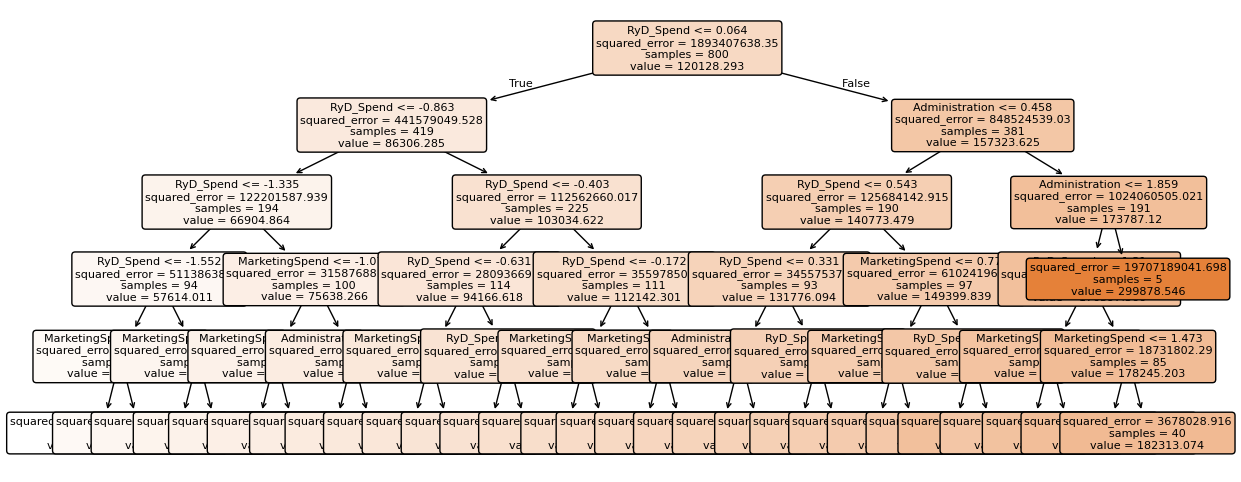

In [26]:
plt.figure(figsize=(14,6))
tree.plot_tree(regressor_tree[1], feature_names=features, fontsize=8, filled=True,
               rounded=True)
plt.show()

In [27]:
# Predicción en el conjunto de entrenamiento
y_pred_a = regressor_tree.predict(X_test)
y_pred_b = regressor_tree.predict(X_test_2)

## Variando parametros manualmente

### 2

In [28]:
regressor_tree_2 = make_pipeline(tree.DecisionTreeRegressor( max_depth=3,min_samples_split= 5, min_samples_leaf=5 ,random_state=24) )

In [29]:
regressor_tree_2.fit(X_train,y_train)

Pipeline(steps=[('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=3, min_samples_leaf=5,
                                       min_samples_split=5, random_state=24))])

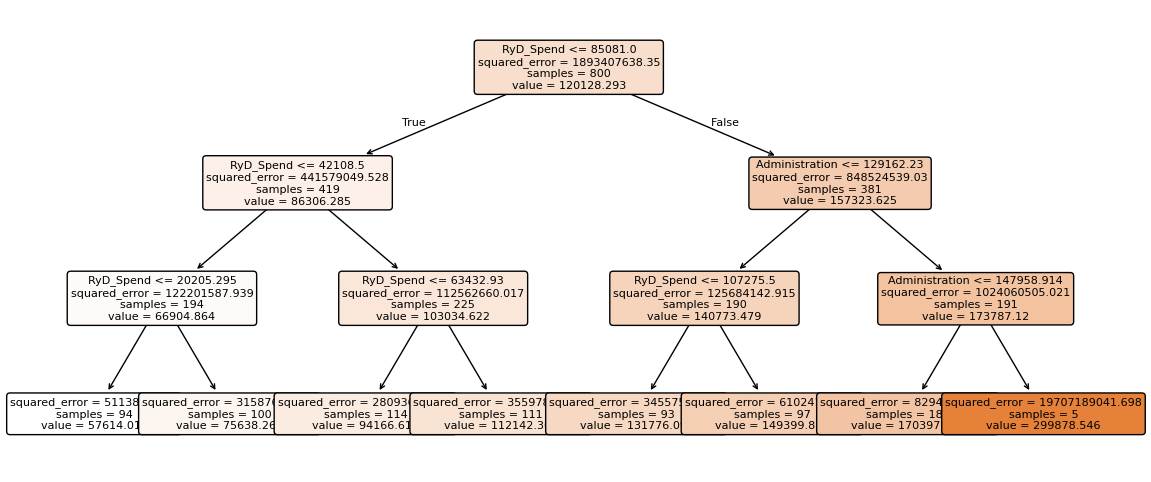

In [30]:
plt.figure(figsize=(14,6))
tree.plot_tree(regressor_tree_2[0], feature_names=features, fontsize=8, filled=True,
               rounded=True)
plt.show()

In [31]:
# Predicción en el conjunto de entrenamiento
y_pred_2_a = regressor_tree_2.predict(X_test)
y_pred_2_b = regressor_tree_2.predict(X_test_2)

### 3

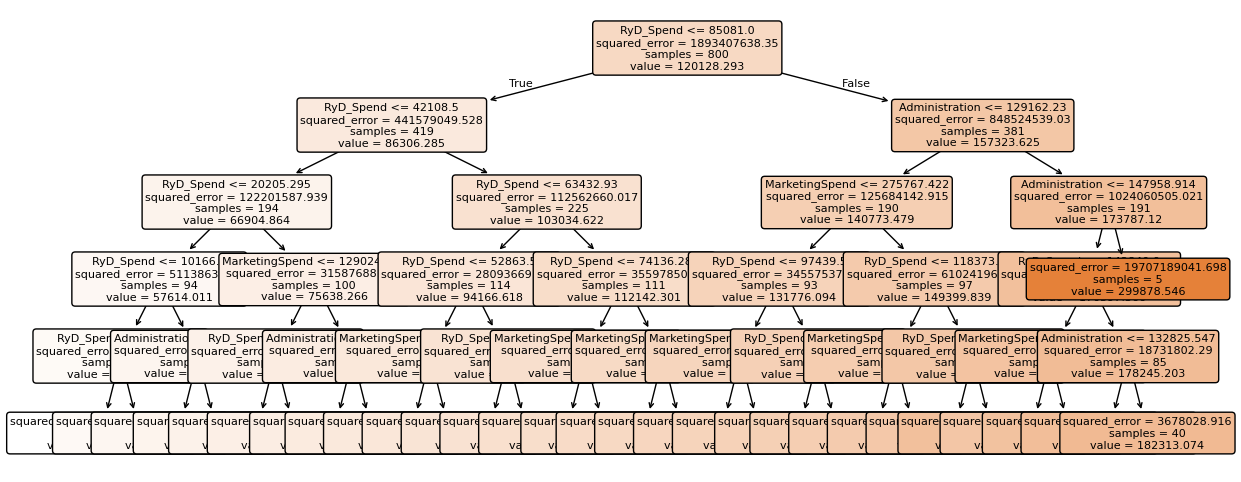

In [32]:
regressor_tree_3 = make_pipeline(tree.DecisionTreeRegressor( max_depth=5,min_samples_split= 10, min_samples_leaf=5 ,random_state=25) )
regressor_tree_3.fit(X_train,y_train)
plt.figure(figsize=(14,6))
tree.plot_tree(regressor_tree_3[0], feature_names=features, fontsize=8, filled=True,
               rounded=True)
plt.show()
# Predicción en el conjunto de entrenamiento
y_pred_3_a = regressor_tree_3.predict(X_test)
y_pred_3_b = regressor_tree_3.predict(X_test_2)

### 4

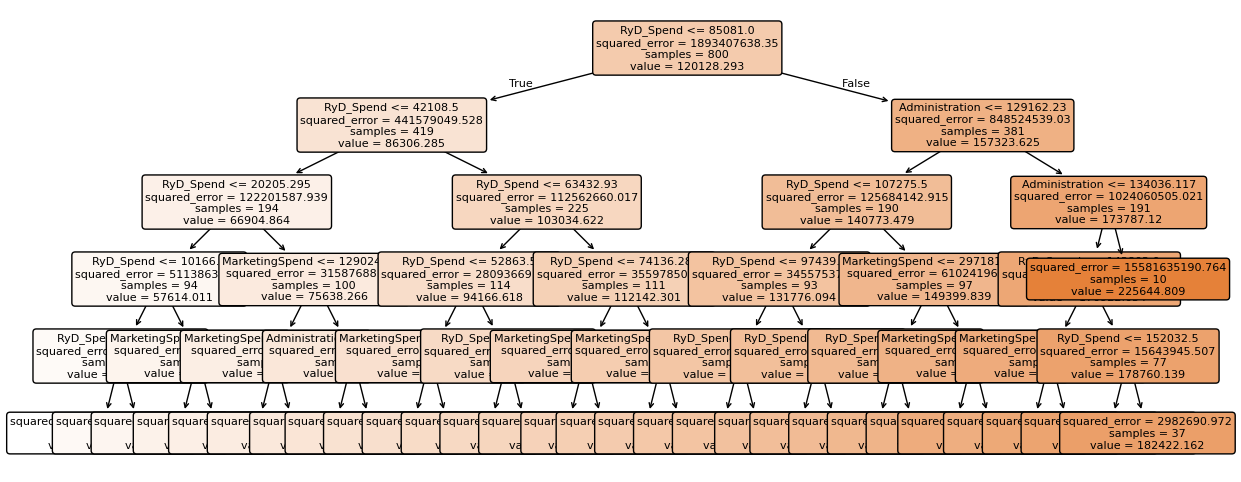

In [33]:
regressor_tree_4 = make_pipeline(tree.DecisionTreeRegressor( max_depth=5,min_samples_split= 5, min_samples_leaf=10 ,random_state=26) )
regressor_tree_4.fit(X_train,y_train)
plt.figure(figsize=(14,6))
tree.plot_tree(regressor_tree_4[0], feature_names=features, fontsize=8, filled=True,
               rounded=True)
plt.show()
# Predicción en el conjunto de entrenamiento
y_pred_4_a = regressor_tree_4.predict(X_test)
y_pred_4_b = regressor_tree_4.predict(X_test_2)

## Metricas

In [34]:
dic_modelos_regressor_tree = {
    'Regressor_tree' : [[5,5,5,'SQR'], (y_test,y_pred_a),(y_test_2,y_pred_b)],
    'Regressor_tree 2' : [[3,5,5,'SQR'], (y_test,y_pred_2_a),(y_test_2,y_pred_2_b)],
    'Regressor_tree 3' : [[5,10,5,'SQR'], (y_test,y_pred_3_a),(y_test_2,y_pred_3_b)],
    'Regressor_tree 4' : [[5,5,10,'SQR'], (y_test,y_pred_4_a),(y_test_2,y_pred_4_b)],
}

In [35]:
metricas = pd_metricas_clasifier(dic_modelos_regressor_tree, 'regressor')

### Metricas con cada intento

In [36]:
metricas

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,MAE Test 1,MSE Test 1,RMSE Test 1,MAE Test 2,MSE Test 2,RMSE Test 2
0,Regressor_tree,5,5,5,SQR,3075.802458,2.041276e+08,14287.324459,3266.902180,1.919151e+08,13853.342901
0,Regressor_tree 2,3,5,5,SQR,6805.059519,2.410551e+08,15525.950449,7292.335508,2.500507e+08,15812.991290
0,Regressor_tree 3,5,10,5,SQR,3143.214182,2.060672e+08,14355.040392,3266.902180,1.919151e+08,13853.342901
0,Regressor_tree 4,5,5,10,SQR,2421.245971,6.041965e+07,7773.007906,4374.773713,3.340563e+08,18277.206024


### Análisis de Influencia de los Parámetros

**Max_Profundidad (Profundidad del árbol):**

Regressor_tree (Profundidad 5) y Regressor_tree_3 (Profundidad 5) tienen el mismo valor para este parámetro. Sus MAE y MSE son relativamente similares (3075.80 y 3143.21 para MAE).

Regressor_tree_2 (Profundidad 3) muestra un aumento significativo en el MAE (6805.06). Esto sugiere que reducir la profundidad del árbol puede resultar en un modelo que no captura adecuadamente la complejidad de los datos, llevando a un mayor error.
Una mayor profundidad generalmente permite al modelo capturar patrones más complejos, pero también puede aumentar el riesgo de sobreajuste.


**Min_Obs (Mínimo de observaciones para una hoja):**

Regressor_tree (5) y Regressor_tree_4 (5) tienen el mismo valor para este parámetro, pero Regressor_tree_4 reduce el mínimo de observaciones por separación (10). Esto resulta en un MAE más bajo (2421.25).

Un menor número de observaciones en una hoja (hojas más "delgadas") puede permitir que el modelo se ajuste más a los datos, resultando en menor error, pero también puede aumentar el riesgo de sobreajuste si se hace excesivamente.


**Min_Obs_x_Sep (Mínimo de observaciones por separación):**

Al comparar Regressor_tree_3 (Min_Obs_x_Sep=5) y Regressor_tree_4 (Min_Obs_x_Sep=10), se observa que aumentar este parámetro en el último modelo reduce significativamente el MAE a 2421.25. Esto sugiere que tener más observaciones requeridas por cada separación puede ayudar a crear divisiones más robustas, resultando en un modelo más generalizable y menos propenso a sobreajuste.


**Criterio_Sep (Criterio de separación):**

En este caso, todos los modelos utilizan el criterio de separación "SQR" (suma de los cuadrados de los residuos). No se pueden comparar directamente otros criterios en este caso, pero cambiar este parámetro en otros escenarios puede afectar la forma en que se construye el árbol.

### **Resumen de Influencias**

Profundidad del árbol: Profundidades más altas tienden a captar patrones más complejos, pero pueden resultar en sobreajuste. Una profundidad demasiado baja puede no capturar la complejidad del problema.

Mínimo de observaciones: Un valor menor permite más flexibilidad en el ajuste del modelo, pero con el riesgo de sobreajuste. Aumentar el número de observaciones por separación tiende a mejorar la generalización del modelo.

Métricas de error: Un MAE, MSE y RMSE más bajos indican un mejor rendimiento del modelo. En este caso, Regressor_tree_4 parece ser el modelo más eficiente, con los errores más bajos, sugiriendo que un equilibrio entre profundidad del árbol y número mínimo de observaciones por separación puede llevar a mejores resultados.

## Optimización de hiperparámetros

In [37]:
escal = StandardScaler()
X_train_scaled = escal.fit_transform(X_train)

In [38]:
param_grid = {
    'max_features': [3, 5, 6, 7, 9],
    'max_depth': [6, 9, 10, 11],
    'min_samples_split' : [3,5,10,20,30],
    'min_samples_leaf' : [3,5,10,15,20 ]
}
random_search = GridSearchCV(tree.DecisionTreeRegressor(),
                                   param_grid)

random_search.fit(X_train_scaled, y_train)


GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [6, 9, 10, 11],
                         'max_features': [3, 5, 6, 7, 9],
                         'min_samples_leaf': [3, 5, 10, 15, 20],
                         'min_samples_split': [3, 5, 10, 20, 30]})

In [39]:
#veo mejores parámetros encontrados
random_search.best_params_

{'max_depth': 11,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 5}

In [40]:
best_prediction = make_pipeline(StandardScaler(), tree.DecisionTreeRegressor(max_depth = 11, max_features=3, min_samples_leaf=3, min_samples_split=3, random_state=7))

In [41]:
best_prediction.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=11, max_features=3,
                                       min_samples_leaf=3, min_samples_split=3,
                                       random_state=7))])

In [42]:
## Hago predicciones test
best_prediction_a = best_prediction.predict(X_test)
best_prediction_b = best_prediction.predict(X_test_2)

In [43]:
dic_best_regressor = {
    'Best Regressor Tree' : [[11,3,3,'SQL'], (y_test, best_prediction_a), (y_test, best_prediction_b)]
}

In [44]:
metricas = pd.concat([metricas, pd_metricas_clasifier(dic_best_regressor, 'regressor')])

In [45]:
metricas

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,MAE Test 1,MSE Test 1,RMSE Test 1,MAE Test 2,MSE Test 2,RMSE Test 2
0,Regressor_tree,5,5,5,SQR,3075.802458,2.041276e+08,14287.324459,3266.902180,1.919151e+08,13853.342901
0,Regressor_tree 2,3,5,5,SQR,6805.059519,2.410551e+08,15525.950449,7292.335508,2.500507e+08,15812.991290
0,Regressor_tree 3,5,10,5,SQR,3143.214182,2.060672e+08,14355.040392,3266.902180,1.919151e+08,13853.342901
0,Regressor_tree 4,5,5,10,SQR,2421.245971,6.041965e+07,7773.007906,4374.773713,3.340563e+08,18277.206024
0,Best Regressor Tree,11,3,3,SQL,1128.375267,1.282685e+07,3581.459269,45078.800747,3.269503e+09,57179.568000


El modelo ajustado con los mejores parámetros claramente supera a los otros modelos en todos los aspectos clave (MAE, MSE, y RMSE). Esto indica que la optimización de los hiperparámetros ha resultado en un modelo mucho más eficiente y preciso para este conjunto de datos.

El ajuste de los parámetros como max_depth y max_features ha mejorado significativamente el rendimiento del modelo, reduciendo los errores y proporcionando mejores predicciones generales. Al reducir la profundidad, se evita que el modelo sobreajuste y, al reducir la cantidad de features que haga un underfitting; encontrar la armonía entre estos dos hiperparámetros permite que el modelo generalice de forma correcta.

Sin embargo, cabe destacar que se ve una performance ampliamente diferente entre los distintos conjuntos de Test.

# Punto 3

Carga de datos

In [46]:
df_pokemon = pd.read_csv('./src/PokemonDBCart.csv')
df_pokemon

,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
0,Bulbasaur,49,49,45,45,65,65,hierba
1,Ivysaur,62,63,60,60,80,80,hierba
2,Venusaur,100,123,80,80,122,120,hierba
3,Charmander,52,43,65,39,60,50,fuego
4,Charmeleon,64,58,80,58,80,65,fuego
...,...,...,...,...,...,...,...,...
474,Buzzwole,139,139,79,107,53,53,bicho
475,Pheromosa,137,37,151,71,137,37,bicho
476,Xurkitree,89,71,83,83,173,71,electrico
477,Kartana,181,131,109,59,59,31,hierba


## Análisis descriptivo

## Tipos de datos

In [47]:
## Cantidad de columnas y sus tipos de datos
print(f'El DataFrame cuenta con un total de {len(df_pokemon.columns)} columnas:')
df_pokemon.dtypes

El DataFrame cuenta con un total de 8 columnas:


Nombre         object
Ataque          int64
Defensa         int64
Velocidad       int64
HP              int64
SpAtaque        int64
SpDefensa       int64
TipoPokemon    object
dtype: object

## Distribuciones y Atípicos.

In [48]:
print(f'Cada columna se comporta de la siguiente manera:')
df_pokemon.describe()

Cada columna se comporta de la siguiente manera:


,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa
count,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000
mean,73.956159,70.657620,66.377871,66.705637,72.778706,70.824635
std,31.507258,29.291417,29.638710,24.807185,32.253524,28.020811
min,5.000000,5.000000,5.000000,1.000000,10.000000,20.000000
25%,50.000000,50.000000,45.000000,50.000000,50.000000,50.000000
50%,70.000000,65.000000,64.000000,65.000000,69.000000,66.000000
75%,94.500000,85.000000,85.000000,78.000000,95.000000,90.000000
max,185.000000,230.000000,180.000000,255.000000,194.000000,230.000000


- Ataque: Sus valores van desde 5 a 185, tiene un promedio de 73.96 y una mediana de 70, lo que infiere que no tiene presencia de atípicos.
- Defensa: Sus valores van desde 5 a 230, tiene un promedio de 70.65 y una mediana de 65, lo que infiere que podría tener algún atípico.
- Velocidad: Sus valores van desde 5 a 180, tiene un promedio de 66.38 y una mediana de 64, lo que infiere que no tiene presencia de atípicos.
- HP: Sus valores van desde 1 a 255, tiene un promedio de 66.71 y una mediana de 65, lo que infiere que no tiene presencia de atípicos.
- SPAtaque: Sus valores van desde 10 a 194, tiene un promedio de 72.78 y una mediana de 69, lo que infiere que podría tener alguna presencia de atípicos.
- SPDefensa: Sus valores van desde 20 a 230, tiene un promedio de 70.82 y una mediana de 66, lo que infiere que tiene presencia de atípicos.

array([[<Axes: title={'center': 'Ataque'}>,
        <Axes: title={'center': 'Defensa'}>],
       [<Axes: title={'center': 'Velocidad'}>,
        <Axes: title={'center': 'HP'}>],
       [<Axes: title={'center': 'SpAtaque'}>,
        <Axes: title={'center': 'SpDefensa'}>]], dtype=object)

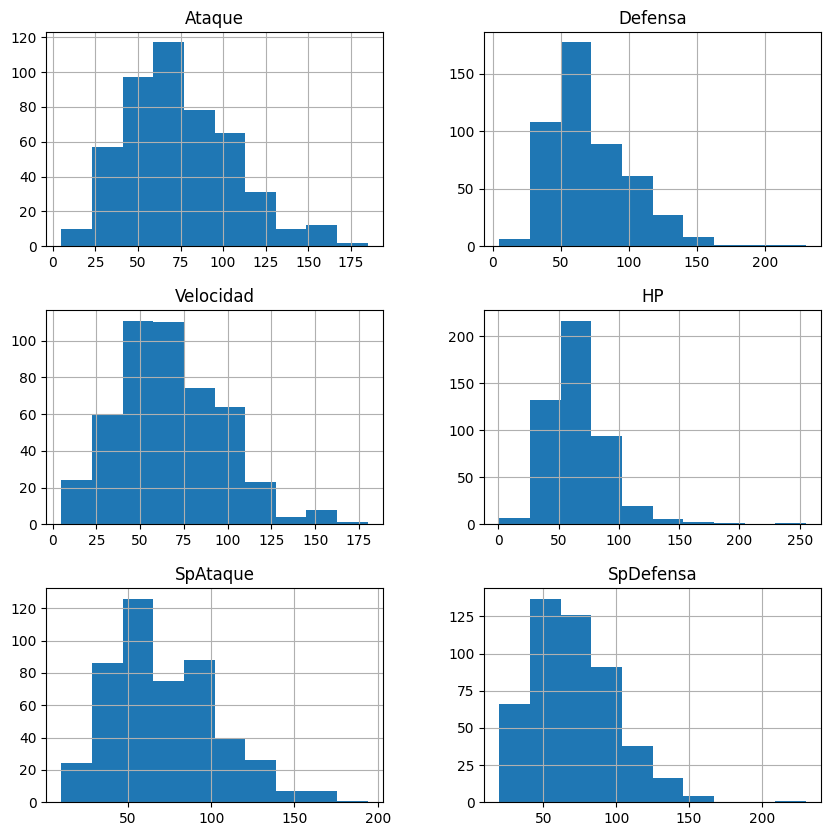

In [49]:
# Vista en histograma
df_pokemon.hist(figsize=(10,10))

La mayoría de las variables tiende a una distribución normal, HP tiene una posible prescencia de atípicos ya que se ve un leve sesgo hacia la derecha, aligual que con SPDefensa y Defensa.
En menor medida, Ataque, Velocidad y SpAtaque.

<Axes: >

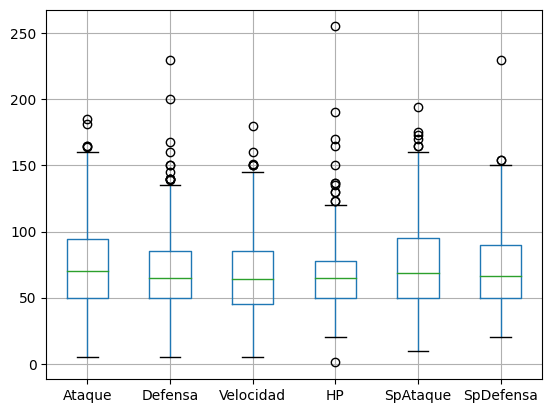

In [50]:
#Vista en boxplot
df_pokemon.boxplot()

Podemos ver que todas las variables tienen presencia de atípicos, las variables que mayor presencia de atípicos tienen son Defensa y HP, seguidas por SpAtaque; luego Ataque, Velocidad y SPDefensa en menor medida.

In [51]:

# Selecciona solo las columnas numéricas
numeric_columns_pok = df_pokemon.select_dtypes(include='number').columns

# Configura el layout del grid en subplots: 2 columnas por fila
rows = len(numeric_columns_pok) // 2 + len(numeric_columns_pok) % 2
fig = make_subplots(rows=rows, cols=2, subplot_titles=numeric_columns_pok)

# Itera sobre las columnas numéricas y crea un histograma por cada una
for i, col in enumerate(numeric_columns_pok):
    # Crear el histograma con Plotly y agrupar por el tipo de Pokémon
    fig_hist = px.histogram(df_pokemon, x=col, color='TipoPokemon', 
                            barmode='overlay')
    show_legend = i == 0 
    # Añadir el histograma a la posición correspondiente en el grid de subplots
    for trace in fig_hist['data']:
        trace.showlegend = show_legend
        fig.add_trace(trace, row=(i // 2) + 1, col=(i % 2) + 1)

# Configurar el layout del gráfico principal
fig.update_layout(
    title="Histograms of Numeric Features by Tipo Pokemon",
    width=1000,  # Ajustar el ancho total de la figura (más espacio para los histogramas)
    height=200 * rows,  # Ajustar la altura total, más alto para dar más espacio por fila
    hovermode="closest",  # Permite resaltar al pasar el cursor
    bargap=0.1,  # Menor espacio entre barras para que se vean más ajustadas
)

# Muestra el gráfico interactivo
fig.show()

Se puede observar que en el caso de Defensa, los valores hacia la derecha no se tratan realmente de atípicos ya que son valores comunes para el tipo de pokemón "Roca"; sin embargo, para las otras variables sí son atípicos.

## Vista de balanceado

<Axes: xlabel='TipoPokemon', ylabel='Count'>

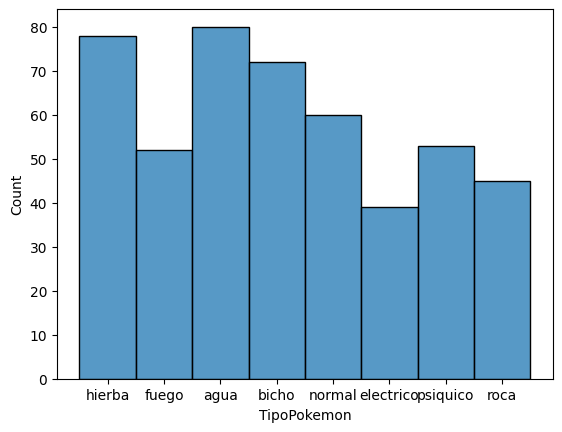

In [52]:
sns.histplot(df_pokemon['TipoPokemon'])

In [53]:
df_pokemon['TipoPokemon'].value_counts()

TipoPokemon
agua         80
hierba       78
bicho        72
normal       60
psiquico     53
fuego        52
roca         45
electrico    39
Name: count, dtype: int64

El dataset se encuentra medianamente balanceado. La clase eléctrico está en gran medida desbalanceada contra las demás, se puede observar que tiene una diferencia de 41 filas contra la que más filas tiene; luego le siguen roca (45), fuego (52) y psíquico(53),
Esto puede afectar a la hora de predecir si no se aplica alguna técnica de balanceo.

### Presencia de Null y Repetidos.

In [54]:
df_pokemon.isnull().any()

Nombre         False
Ataque         False
Defensa        False
Velocidad      False
HP             False
SpAtaque       False
SpDefensa      False
TipoPokemon    False
dtype: bool

No hay presencia de datos nulos.

In [55]:
df_pokemon.duplicated().any()

False

No hay filas duplicadas.

## Correlación.

<Axes: >

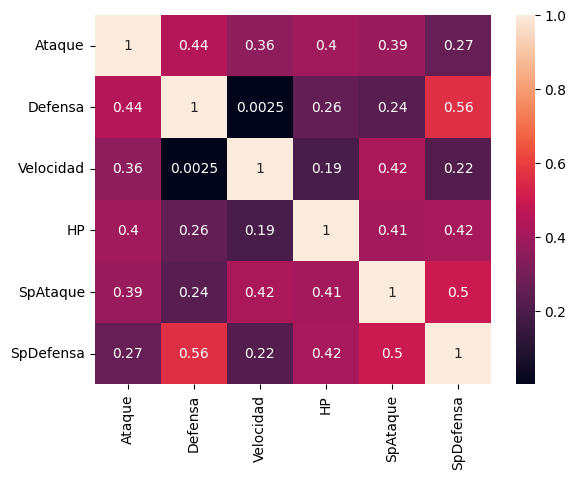

In [56]:
corr_pok = df_pokemon[numeric_columns_pok].corr()
sns.heatmap(corr_pok, annot= True)

Las variables presentan todas correlaciones positivas.
Las variables con mayor fuerza de correlación son:
- Defensa - SpDefensa : 0.56. Es una correlación moderada.
- SpAtaque - SpDefensa: 0.5. Correlación moderada.
- Defensa - Ataque : 0.44. Correlación moderada-baja.

En general, no hay correlaciones fuertes que indiquen una tendencia a una correlación fuertemente lineal.


# Modelos

## Preparación de datos

In [57]:
# Quita nombre ya que no es relevante
df_pokemon_sub = df_pokemon.drop(columns='Nombre')

In [58]:
X_pok = df_pokemon_sub.drop(columns='TipoPokemon') 
y_pok = df_pokemon_sub['TipoPokemon']

In [59]:
X_train_pok, X_test_pok, y_train_pok, y_test_pok = train_test_split(X_pok , y_pok, test_size=0.2, random_state=10)

In [60]:
X_train_pok_2, X_test_pok_2, y_train_pok_2, y_test_pok_2 = train_test_split(X_pok , y_pok, test_size=0.2, random_state=67)

# Punto 4: Árbol de Clasificación.

Realizar la estimación del atributo TipoPokemon utilizando árboles de decisión 
(Clasificación) analizando los parámetros máximo profundidad, número mínimo de 
observaciones, número mínimo de observaciones por separación y criterio de separación. 
Graficar un árbol obtenido en el proceso de entrenamiento y luego a aplicar una poda. 
Mostrar los resultados sobre ambos conjuntos de test (Precisión, Exhaustividad y 
Exactitud).

In [61]:
clas_tree = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(max_depth=5,min_samples_split= 5, min_samples_leaf=5, splitter= 'best',random_state=13), )

In [62]:
clas_tree.fit(X_train_pok,y_train_pok)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=5,
                                        min_samples_split=5,
                                        random_state=13))])

In [63]:
y_pred_pok_clas = clas_tree.predict(X_test_pok)
y_2_pred_pok_clas = clas_tree.predict(X_test_pok_2)

In [64]:
features_pok = list(X_train_pok.columns)

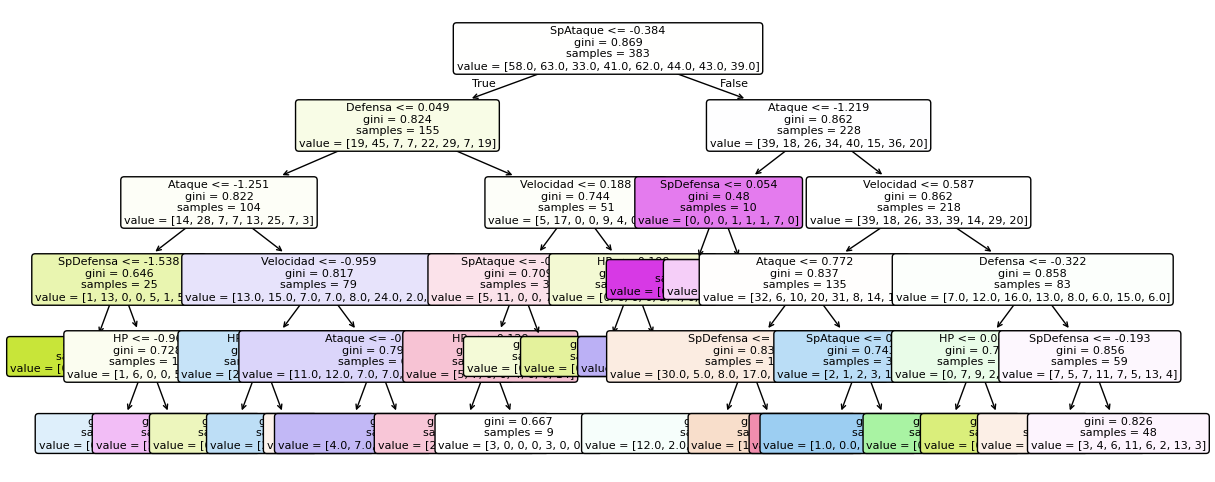

In [65]:
plt.figure(figsize=(14,6))
tree.plot_tree(clas_tree[1], feature_names=features_pok, fontsize=8, filled=True,
               rounded=True)
plt.show()

##**HABLAR SOBRE GINNI**

## Variando Parámetros Manualmente

### 2

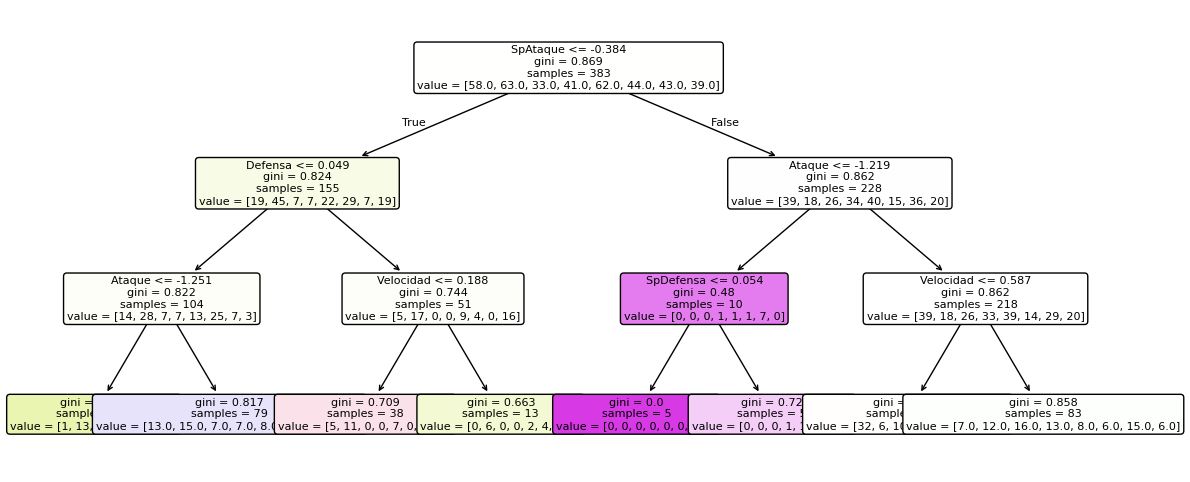

In [66]:
clas_tree_2 = make_pipeline(StandardScaler(),tree.DecisionTreeClassifier(max_depth=3,min_samples_split= 5, min_samples_leaf=5, splitter= 'best',random_state=14), )
clas_tree_2.fit(X_train_pok,y_train_pok)
y_pred_pok_clas_2 = clas_tree_2.predict(X_test_pok)
y_2_pred_pok_clas_2 = clas_tree.predict(X_test_pok_2)
plt.figure(figsize=(14,6))
tree.plot_tree(clas_tree_2[1], feature_names=features_pok, fontsize=8, filled=True,
               rounded=True)
plt.show()

### 3

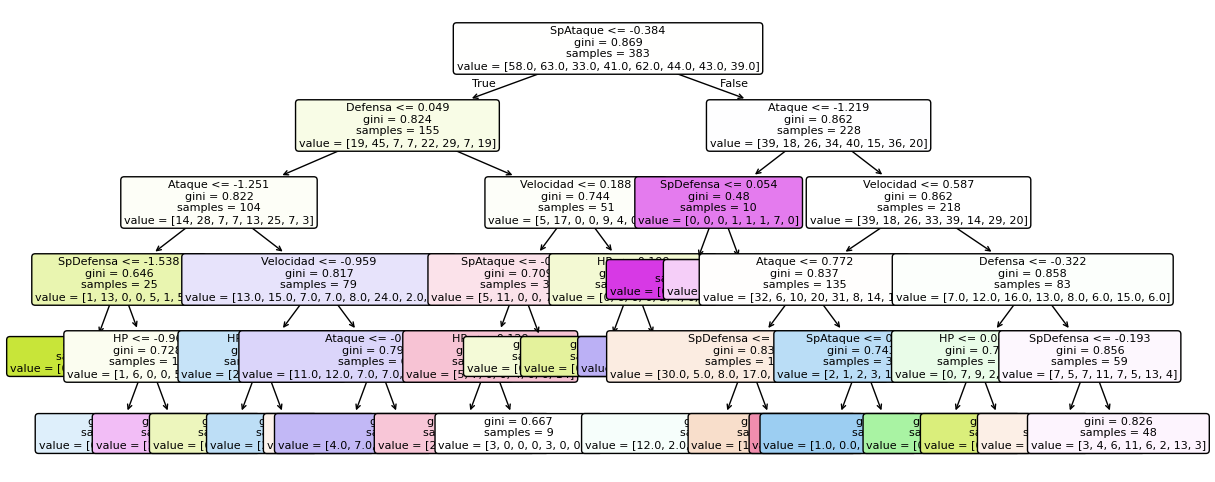

In [67]:
clas_tree_3 = make_pipeline(StandardScaler(),tree.DecisionTreeClassifier(max_depth=5,min_samples_split= 10, min_samples_leaf=5, splitter= 'best',random_state=15), )
clas_tree_3.fit(X_train_pok,y_train_pok)
y_pred_pok_clas_3 = clas_tree_3.predict(X_test_pok)
y_2_pred_pok_clas_3 = clas_tree.predict(X_test_pok_2)
plt.figure(figsize=(14,6))
tree.plot_tree(clas_tree_3[1], feature_names=features_pok, fontsize=8, filled=True,
               rounded=True)
plt.show()

### 4

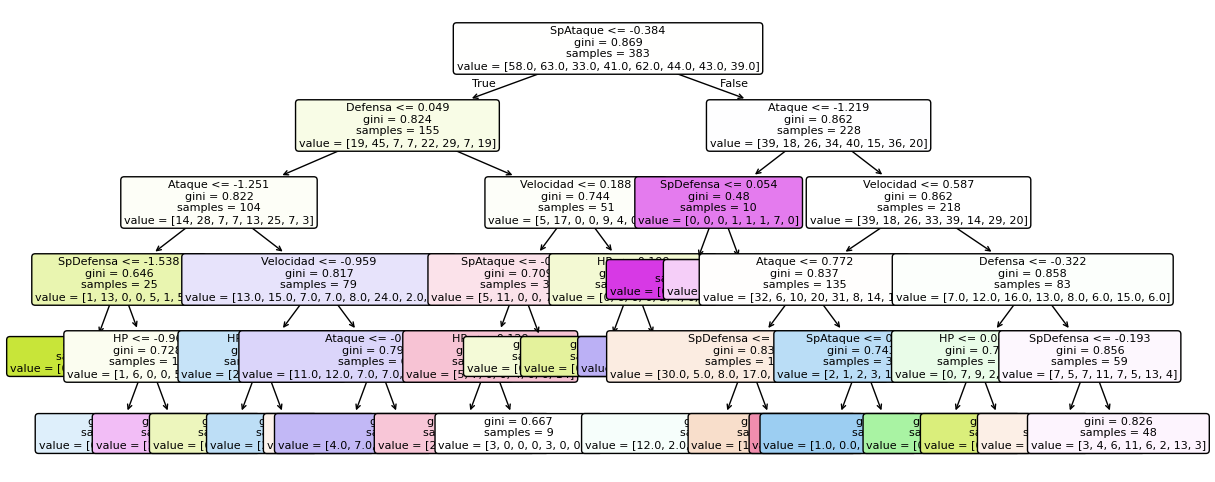

In [68]:
clas_tree_4 = make_pipeline(StandardScaler(),tree.DecisionTreeClassifier(max_depth=5,min_samples_split= 10, min_samples_leaf=5, splitter= 'best',random_state=16), )
clas_tree_4.fit(X_train_pok,y_train_pok)
y_pred_pok_clas_4 = clas_tree_4.predict(X_test_pok)
y_2_pred_pok_clas_4 = clas_tree.predict(X_test_pok_2)
plt.figure(figsize=(14,6))
tree.plot_tree(clas_tree_4[1], feature_names=features_pok, fontsize=8, filled=True,
               rounded=True)
plt.show()

## Métricas

#### Matrices de confusión

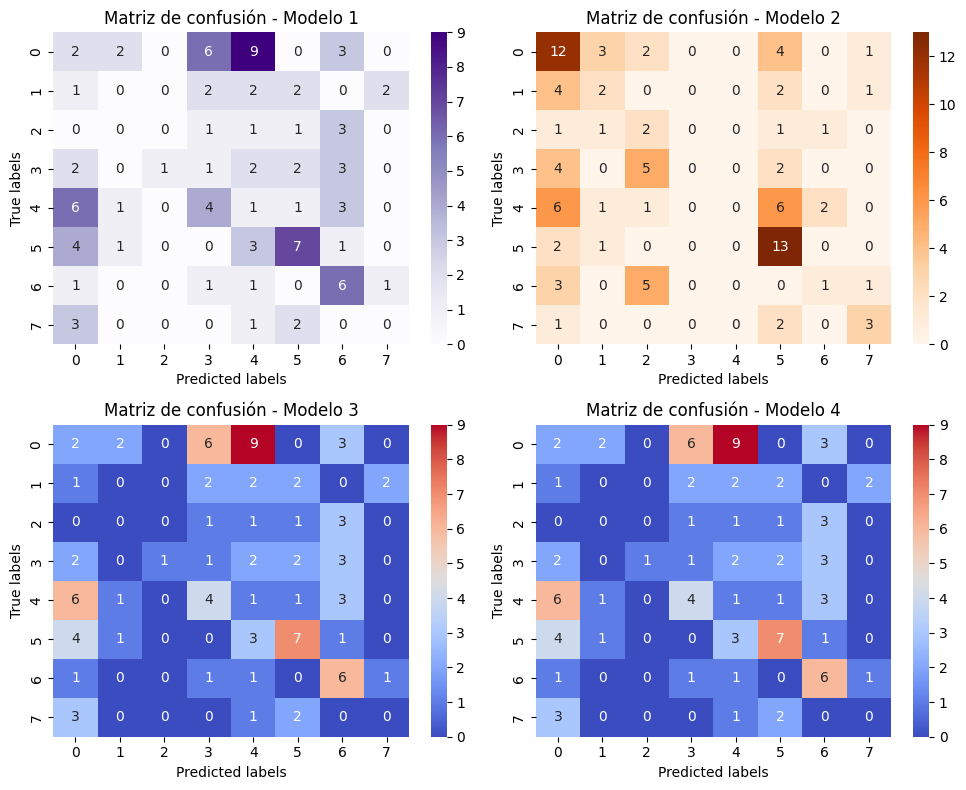

In [69]:
plot_multiple_conf_matrices(
    [y_test_pok,y_test_pok,y_test_pok,y_test_pok],
    [y_pred_pok_clas,y_pred_pok_clas_2,y_pred_pok_clas_3,y_pred_pok_clas_4],
    ['Matriz de confusión - Modelo 1','Matriz de confusión - Modelo 2','Matriz de confusión - Modelo 3','Matriz de confusión - Modelo 4']
      )

### Otras Metricas

In [70]:
dic_modelo_tree ={
    'Clasification_tree' : [[5,5,5,'Best'],(y_test_pok,y_pred_pok_clas),(y_test_pok,y_2_pred_pok_clas)],
    'Clasification_tree_2': [[3,5,5,'Best'], (y_test_pok,y_pred_pok_clas_2),(y_test_pok,y_2_pred_pok_clas_2)],
    'Clasification_tree_3': [[5,10,5,'Best'],(y_test_pok,y_pred_pok_clas_3),(y_test_pok,y_2_pred_pok_clas_3)],
    'Clasification_tree_4': [[5,10,5,'Best'],(y_test_pok,y_pred_pok_clas_4),(y_test_pok,y_2_pred_pok_clas_4)]
}
metricas_modelos_tree = pd_metricas_clasifier(
    dic_modelo_tree
)

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_lab

In [71]:
metricas_modelos_tree

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2
0,Clasification_tree,5,5,5,Best,0.150768,0.177083,0.177083,0.158803,0.129639,0.114583,0.114583,0.120248
0,Clasification_tree_2,3,5,5,Best,0.244618,0.343750,0.343750,0.274297,0.129639,0.114583,0.114583,0.120248
0,Clasification_tree_3,5,10,5,Best,0.150768,0.177083,0.177083,0.158803,0.129639,0.114583,0.114583,0.120248
0,Clasification_tree_4,5,10,5,Best,0.150768,0.177083,0.177083,0.158803,0.129639,0.114583,0.114583,0.120248


## Optimización de Hiperparámetros

In [72]:
scaler = StandardScaler()
X_train_pok_escaled =  scaler.fit_transform(X_train_pok)

In [73]:
param_grid_pok = {
    'max_features': [3, 5, 6, 7, 9],
    'max_depth': [5, 6, 9, 10, 11],
    'min_samples_split':[5,10,15,20,25],
    'min_samples_leaf': [3,5,10,15,20],
    'splitter': ['best', 'random'],
    'random_state': [18]
}
grid_search_pok = GridSearchCV(tree.DecisionTreeClassifier(),
                                   param_grid_pok )

grid_search_pok.fit(X_train_pok_escaled, y_train_pok)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 6, 9, 10, 11],
                         'max_features': [3, 5, 6, 7, 9],
                         'min_samples_leaf': [3, 5, 10, 15, 20],
                         'min_samples_split': [5, 10, 15, 20, 25],
                         'random_state': [18], 'splitter': ['best', 'random']})

In [74]:
#veo mejores parámetros encontrados
grid_search_pok.best_params_

{'max_depth': 6,
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'random_state': 18,
 'splitter': 'best'}

In [75]:
best_tree_pok = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(min_samples_split= 10, min_samples_leaf=3, max_features=5, max_depth=6, splitter='best'))

In [76]:
best_tree_pok.fit(X_train_pok,y_train_pok)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, max_features=5,
                                        min_samples_leaf=3,
                                        min_samples_split=10))])

In [77]:
## Hago predicciones test
best_prediction_pok = best_tree_pok.predict(X_test_pok)
best_2_prediction_pok = best_tree_pok.predict(X_test_pok_2)

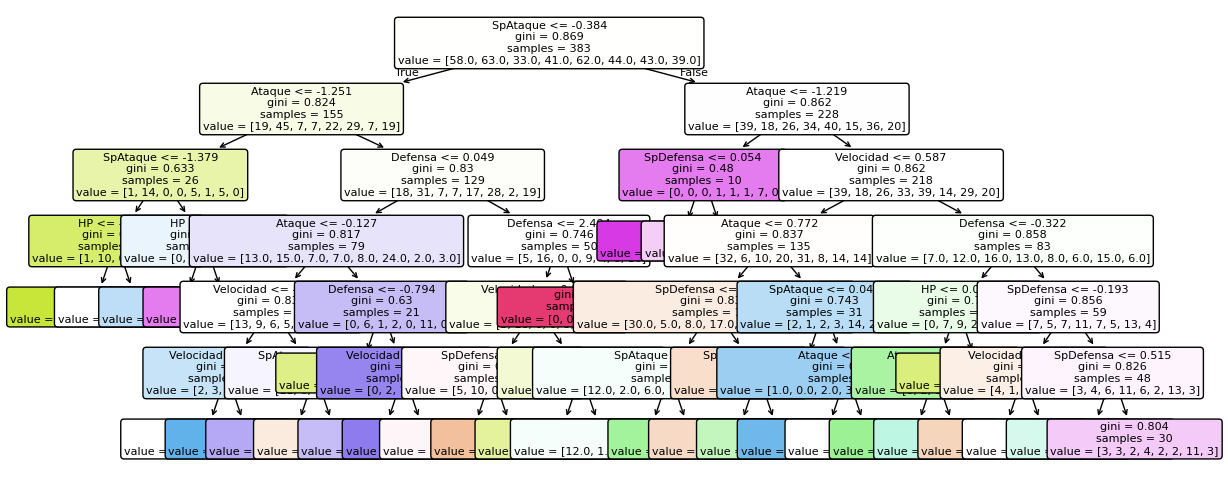

In [78]:
plt.figure(figsize=(14,6))
tree.plot_tree(best_tree_pok[1], feature_names=features_pok, fontsize=8, filled=True,
               rounded=True)
plt.show()

In [79]:
dict_best = {
    'Best Clasification_tree' : [[6,3,5,'Best'], (y_test_pok, best_prediction_pok), (y_test_pok, best_2_prediction_pok)]
}
metricas_modelos_tree = pd.concat([metricas_modelos_tree, pd_metricas_clasifier(dict_best)])

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_lab

In [80]:
metricas_modelos_tree

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2
0,Clasification_tree,5,5,5,Best,0.150768,0.177083,0.177083,0.158803,0.129639,0.114583,0.114583,0.120248
0,Clasification_tree_2,3,5,5,Best,0.244618,0.343750,0.343750,0.274297,0.129639,0.114583,0.114583,0.120248
0,Clasification_tree_3,5,10,5,Best,0.150768,0.177083,0.177083,0.158803,0.129639,0.114583,0.114583,0.120248
0,Clasification_tree_4,5,10,5,Best,0.150768,0.177083,0.177083,0.158803,0.129639,0.114583,0.114583,0.120248
0,Best Clasification_tree,6,3,5,Best,0.248943,0.260417,0.260417,0.240377,0.133731,0.125000,0.125000,0.124554


Podemos ver cómo cambia significativamente las métricas al obtener los mejores parametros mediante GridSearch en comparación a los otros modelos, a excepción del modelo 2. En comparación con dicho modelo, el modelo Best 'pierde' en algunas métricas:
- Recall: el modelo 2 tiene mejor recall, no así presición donde tiene 0.03 puntos menos.
- F1 score da mayor dado en modelo 2 ya que la diferencia (0.08) con el recall del modelo Best es más grande que la pérdida de precisión (0.03).
- Accuracy: también es mejor el del modelo 2.

Es decir, el modelo 2 tiene un mejor comportamiento general que el mejor encontrado por GridSearch. Sin embargo, los hiperparámetros encontrados tienen sentido ya que GridSearch optimiza por Precision.

# Punto 5: Bayes Ingenuo

Realizar la estimación del atributo TipoPokemon utilizando Bayes Ingenuo. Aquí deberá
considerar un criterio de división de los atributos para discretizarlos. Mostrar los resultados
sobre ambos conjuntos de test (Precisión, Exhaustividad y Exactitud).

In [81]:
def discretizacion(X):
    '''
    Toma un df X y devuelve dicho df discretizado para Bayes Ingenuo
    '''
    label_encoder = LabelEncoder()
    X_discreto = X.copy()
    for c in X.columns:
        X_discreto[c] = label_encoder.fit_transform(X_discreto[c])

    return X_discreto

In [82]:
X_train_pok_discreto = discretizacion(X_train_pok)
X_test_pok_discreto = discretizacion(X_test_pok)
X_test_2_pok_discreto = discretizacion(X_test_pok_2)

In [83]:
model_bayes = make_pipeline(GaussianNB())
model_bayes.fit(X_train_pok_discreto, y_train_pok)

Pipeline(steps=[('gaussiannb', GaussianNB())])

In [84]:
y_train_pok_pred_bayes = model_bayes.predict(X_train_pok_discreto)
y_test_pok_pred_bayes = model_bayes.predict(X_test_pok_discreto)
y_test_2_pok_pred_bayes = model_bayes.predict(X_test_2_pok_discreto)

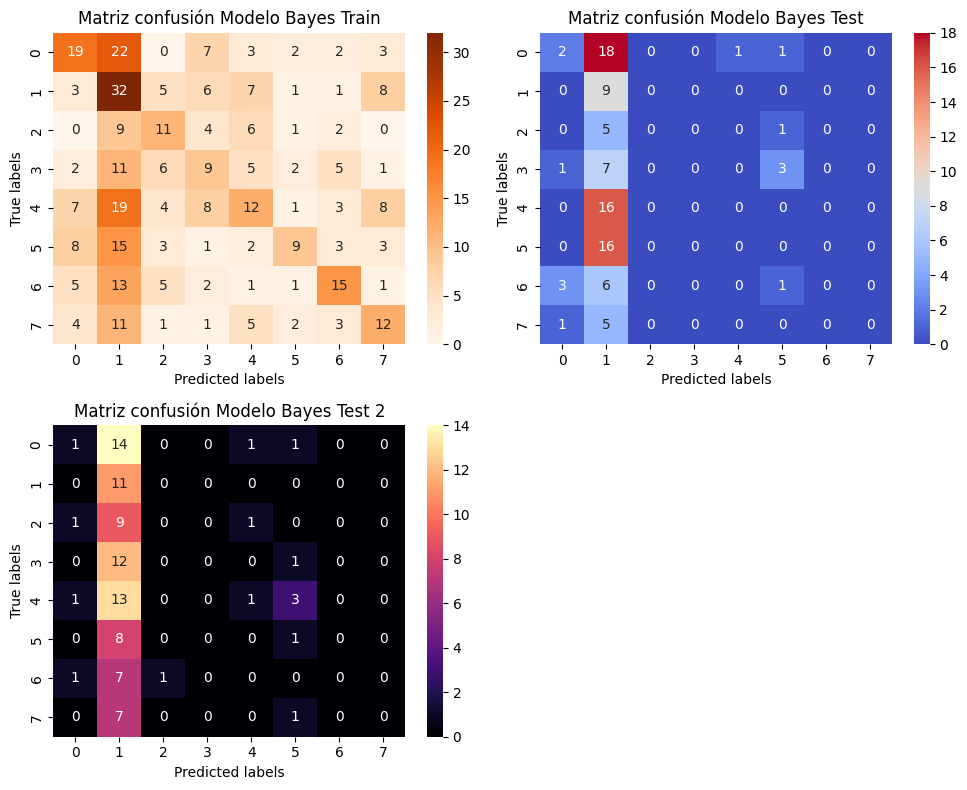

In [85]:
plot_multiple_conf_matrices(
    [y_train_pok,y_test_pok,y_test_pok_2],
    [y_train_pok_pred_bayes,y_test_pok_pred_bayes,y_test_2_pok_pred_bayes],
    ['Matriz confusión Modelo Bayes Train', 'Matriz confusión Modelo Bayes Test', 'Matriz confusión Modelo Bayes Test 2'])

Observaciones:
- Clase 0: Agua.
- Clase 1: Bicho.
- Clase 2: Eléctrico.
- Clase 3: Fuego.
- Clase 4: Hierba.
- Clase 5: Normal.
- Clase 6: Psíquico.
- Clase 7: Roca.

In [88]:
y_train_pok.value_counts()

TipoPokemon
bicho        63
hierba       62
agua         58
normal       44
psiquico     43
fuego        41
roca         39
electrico    33
Name: count, dtype: int64

Se observa que no tiene una buena performance en cuanto a la clasificación correcta de las clases:
- Sobre conjunto Train (matriz superior izquierda):  Podemos ver como de las 58 etiquetas de 'Agua' (clase 0) solo predice bien 22 confusión con predecirlas como 'Bicho' (clase 1). Esta última clase es la que parece tener mejores valores ded verdaderos positivos, teniendo 32 casos bien clasificados de los (63). Sin embargo sigue siendo bajo (50% de esta clase solo fue bien clasificada).
- Sobre el conjunto Test 1 (matriz superior derecha): tiene una buena performance solo para la clase 'Bicho' (clase 1) la cual clasifica a la perfección. Sin embargo, muy mala performance para el resto.
- Sobre el conjunto Test 2 (matriz inferior izquierda): Se repite el caso del conjunto Test 1.

Las performance de ambos conjuntos test tienen sentidos ya que 'traslada' lo aprendido en el train.

In [100]:
## Métricas
dict_bayes = {
    'Modelo Bayes': [[None, None, None, None], (y_train_pok,y_train_pok_pred_bayes), (y_test_pok,y_test_pok_pred_bayes), (y_test_pok_2, y_test_2_pok_pred_bayes)]
}
metricas_bayes = pd_metricas_clasifier(dict_bayes)

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_lab

In [101]:
metricas_bayes

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,Modelo Bayes,None,None,None,None,0.337525,0.310705,0.310705,0.307412,0.075766,0.114583,0.114583,0.050153,0.135724,0.145833,0.145833,0.073841


Se puede observar que este modelo está sobreajustando ya que tiene rendimientos muy disparejos para el test 1(sobre el conjunto de train) y test 2 y test 3. Siendo mucho más bajos los rendimientos en comparación con los modelos implementados anteriormente.

## Optimización de hiperparámetros Bayes.

In [96]:
scaler_bayes = StandardScaler()
X_train_pok_discreto_sc = scaler_bayes.fit_transform(X_train_pok_discreto)
X_test_pok_discreto_sc = scaler_bayes.transform(X_test_pok_discreto)
X_test_2_pok_discreto_sc = scaler_bayes.transform(X_test_2_pok_discreto)

In [97]:
model_bayes_sc = GaussianNB()
model_bayes_sc.fit(X_train_pok_discreto_sc,y_train_pok)

GaussianNB()

In [98]:
y_train_pok_pred_bayes_sc = model_bayes_sc.predict(X_train_pok_discreto_sc)
y_test_pok_pred_bayes_sc = model_bayes_sc.predict(X_test_pok_discreto_sc)
y_test_2_pok_pred_bayes_sc = model_bayes_sc.predict(X_test_2_pok_discreto_sc)

In [102]:
## Métricas
dict_bayes_sc = {
    'Modelo Bayes SC': [[None, None, None, None], (y_train_pok,y_train_pok_pred_bayes_sc), (y_test_pok,y_test_pok_pred_bayes_sc), (y_test_pok_2, y_test_2_pok_pred_bayes_sc)]
}
metricas_bayes = pd.concat([metricas_bayes,pd_metricas_clasifier(dict_bayes_sc)])

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_lab

In [103]:
metricas_bayes

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,Modelo Bayes,None,None,None,None,0.337525,0.310705,0.310705,0.307412,0.075766,0.114583,0.114583,0.050153,0.135724,0.145833,0.145833,0.073841
0,Modelo Bayes SC,None,None,None,None,0.337525,0.310705,0.310705,0.307412,0.075766,0.114583,0.114583,0.050153,0.135724,0.145833,0.145833,0.073841


Observamos que la performance es la misma, por lo que podemos intentar optimizar ciertos hiperparámetros:
- var_smoothing: ayuda a controlar la estabilidad del modelo añadiendo una pequeña cantidad a la varianza de cada característica, útil cuando algunas características tienen baja varianza.

In [107]:
model_grid_bayes = GaussianNB()
param_grid_bayes= { 'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
best_model_bayes = GridSearchCV(model_grid_bayes, param_grid_bayes, scoring='f1_weighted', cv=5)
best_model_bayes.fit(X_train_pok_discreto, y_train_pok)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001]},
             scoring='f1_weighted')

In [108]:
best_model_bayes.best_params_

{'var_smoothing': 1e-09}

In [109]:
y_train_pok_pred_bayes_best = best_model_bayes.predict(X_train_pok_discreto)
y_test_pok_pred_bayes_best = best_model_bayes.predict(X_test_pok_discreto)
y_test_2_pok_pred_bayes_best = best_model_bayes.predict(X_test_2_pok_discreto)

In [110]:
## Métricas
dict_bayes_best = {
    'Modelo Bayes con var_smoothing 1e-09': [[None, None, None, None], (y_train_pok,y_train_pok_pred_bayes_best), (y_test_pok,y_test_pok_pred_bayes_best), (y_test_pok_2, y_test_2_pok_pred_bayes_best)]
}
metricas_bayes = pd.concat([metricas_bayes,pd_metricas_clasifier(dict_bayes_best)])

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.

C:\Users\julil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1583: UserWarning:

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_lab

In [111]:
metricas_bayes

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,Modelo Bayes,None,None,None,None,0.337525,0.310705,0.310705,0.307412,0.075766,0.114583,0.114583,0.050153,0.135724,0.145833,0.145833,0.073841
0,Modelo Bayes SC,None,None,None,None,0.337525,0.310705,0.310705,0.307412,0.075766,0.114583,0.114583,0.050153,0.135724,0.145833,0.145833,0.073841
0,Modelo Bayes con var_smoothing 1e-09,None,None,None,None,0.337525,0.310705,0.310705,0.307412,0.075766,0.114583,0.114583,0.050153,0.135724,0.145833,0.145833,0.073841


# Punto 6: K-NN

Realizar la estimación del atributo TipoPokemon utilizando k-NN analizando los
parámetros cantidad de vecinos, métrica y valor de p. Mostrar los resultados sobre ambos
conjuntos de test (Precisión, Exhaustividad y Exactitud).